# DeepRouteSet
DeepRouteSet uses LSTM to generate new moonboard problem. 
It is modified from the homework "Improvise a Jazz Solo with an LSTM Network" of Coursera course "Sequence Model".
Yi-Shiou Duh(Allenduh@stanford.edu)

In [4]:
from __future__ import print_function
import IPython
import sys
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import pickle
import os
import keras
import tensorflow as tf
import keras.backend as K
import re
from keras.models import load_model, Model
from keras.layers import Dense, Activation, Input, LSTM, Reshape, Lambda, RepeatVector
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.cbook as cbook
import re 
import matplotlib.pyplot as plt
import PIL
plt.rcParams["figure.figsize"] = (30,10)
from DeepRouteSetHelper import *

c:/Users/Matt/Desktop/rnn/MoonBoardRNN/preprocessing/benchmark_handString_seq_X


## 1 - Data preparation

We want more moonboard problems, and high-quality, hard moonboard problem is especially not enough. Thanksfully, with LSTM, we can generate unlimited problems. By carefully choosing the source of author and 3 stars high quality problems, we can generate new moonboard problem of better quality.


### 1.1 - Dataset

We will train our RNN using a sequence of moves. We already preprocessed moonboard problems from a set of holds (e.g., [8A, 11B, 13C, ...]) to the list of holds with designated hand operation (e.g., [8A-LH, 11B-RH...]). Each point will be assigned to a moonboard "value". After training, RNN will then be able to generate new move sequences.

### 1.2 - Define Path to read handString_seq

5 files: Handsequence (benchmark YN/ grade YN) and raw data with URL: 

In [2]:
cwd = os.getcwd()
parent_wd = cwd.replace('\\', '/').replace('/model', '')

In [3]:
benchmark_handString_seq_path = parent_wd + '/preprocessing/benchmark_handString_seq_X'
benchmarkNoGrade_handString_seq_path = parent_wd + '/preprocessing/benchmarkNoGrade_handString_seq_X'
nonbenchmark_handString_seq_path = parent_wd + '/preprocessing/nonbenchmark_handString_seq_X'
nonbenchmarkNoGrade_handString_seq_path = parent_wd + '/preprocessing/nonbenchmarkNoGrade_handString_seq_X'

url_data_path = parent_wd + '/raw_data/moonGen_scrape_2016_cp'

In [4]:
with open(benchmark_handString_seq_path, 'rb') as f:
    benchmark_handString_seq = pickle.load(f)
with open(benchmarkNoGrade_handString_seq_path, 'rb') as f:
    benchmarkNoGrade_handString_seq = pickle.load(f)
with open(nonbenchmark_handString_seq_path, 'rb') as f:
    nonbenchmark_handString_seq = pickle.load(f)
with open(nonbenchmarkNoGrade_handString_seq_path, 'rb') as f:
    nonbenchmarkNoGrade_handString_seq = pickle.load(f)   
with open(url_data_path, 'rb') as f:
    MoonBoard_2016_withurl = pickle.load(f)    

In [5]:
# Example of input sequence
benchmark_handString_seq["189344"]

['B4-LH', 'D6-RH', 'F9-LH', 'G11-RH', 'C15-LH', 'H18-RH']

In [6]:
# raw data URL file looks like
MoonBoard_2016_withurl["189344"]

{'problem_name': 'JUST TRAINING',
 'info': ['Alex Biale',
  '195 climbers have repeated this problem',
  '7C+ (User grade 8A)',
  'Feet follow hands',
  ''],
 'url': 'https://moonboard.com/Problems/View/189344/just-training',
 'num_empty': 0,
 'num_stars': 3,
 'moves': [{'Id': 1879483,
   'Description': 'B4',
   'IsStart': True,
   'IsEnd': False},
  {'Id': 1879484, 'Description': 'C15', 'IsStart': False, 'IsEnd': False},
  {'Id': 1879485, 'Description': 'D6', 'IsStart': True, 'IsEnd': False},
  {'Id': 1879486, 'Description': 'F9', 'IsStart': False, 'IsEnd': False},
  {'Id': 1879487, 'Description': 'G11', 'IsStart': False, 'IsEnd': False},
  {'Id': 1879488, 'Description': 'H18', 'IsStart': False, 'IsEnd': True}],
 'grade': '7C+',
 'UserGrade': '8A',
 'isBenchmark': True,
 'repeats': 195,
 'ProblemType': 'Crimp',
 'IsMaster': False,
 'setter': {'Id': '7A90397F-74F9-4858-846B-D3CA9E4F70FF',
  'Nickname': 'Alex Biale',
  'Firstname': 'Alex',
  'Lastname': 'Biale',
  'City': 'Boulder',
  '

### 1.3 - Pick good moonboard problem 

Only pick the problem by choosing good setter and pick 3 starts problems. Store in the goodKeyList

* Collect Name of all setters

In [7]:
# All setter with non error name
setterList = []
countNumOfErrorUsername = 0
for key in MoonBoard_2016_withurl.keys(): 
    try:
        setterList.append(MoonBoard_2016_withurl[key]['setter']['Nickname'])
    except:
        countNumOfErrorUsername += 1

* Each setters' experience

In [8]:
#Counter(setterList)
setterDict = {k: v for k, v in sorted(Counter(setterList).items(), key=lambda item: item[1], reverse = True)}

* Add experienced setter and Benchmark setter

In [9]:
# add setter with 50+ experience and Benchmark setter
goodSetterName = []
for key in setterDict.keys():
    if setterDict[key] > 50:
        goodSetterName.append(key)
for key in MoonBoard_2016_withurl.keys(): 
    try:
        if MoonBoard_2016_withurl[key]['isBenchmark'] == True:
            goodSetterName.append(MoonBoard_2016_withurl[key]['setter']['Nickname'])
    except:
        pass
print("Total good setter: ", len(goodSetterName))     

Total good setter:  425


* Define a goodProblemKeyList

In [10]:
# Pick Extended BenchMark, high repeat number, author make many problem, high rate
count = 0
goodProblemKeyList = []
for key in MoonBoard_2016_withurl.keys():  
    try:
        if MoonBoard_2016_withurl[key][isBenchmark] == True:
            goodSetterName.append(MoonBoard_2016_withurl[key]['setter']['Nickname'])   
    except:
        pass

    
for key in MoonBoard_2016_withurl.keys():  
    try:
        if MoonBoard_2016_withurl[key]['setter']['Nickname'] in goodSetterName:
            goodProblemKeyList.append(key)
            count = count + 1
        if MoonBoard_2016_withurl[key]['isBenchmark'] == True:
            goodProblemKeyList.append(key)
            count = count + 1
        if MoonBoard_2016_withurl[key]['repeats'] > 50:
            goodProblemKeyList.append(key)
            count = count + 1
        if MoonBoard_2016_withurl[key]['num_stars'] == 3:
            goodProblemKeyList.append(key) 
            count = count + 1
    except:
        pass
print ("Total amount of good problems: ", count)

Total amount of good problems:  19842


### 1.3 - Grade filter

We will seperate problems into 3 difficulty range: Hard (V8 and up) medium (V6 to V8) and easy (V4 V5). So that our training set has the similar difficulty. This will help the problems generated to be more consistant in the difficulty.

In [11]:
easyProblemKeyList = []
mediumProblemKeyList = []
hardProblemKeyList = []
for key in goodProblemKeyList:
    if MoonBoard_2016_withurl[key]['grade'] in ["6B+", "6C", "6C+"]: # V4 V5
            easyProblemKeyList.append(key)
    if MoonBoard_2016_withurl[key]['grade'] in ["7A", "7A+", "7B", "7B+"]: # V6 7 8
            mediumProblemKeyList.append(key)
    if MoonBoard_2016_withurl[key]['grade'] in ["7B", "7B+", "7C", "7C+", "8A", "8A+", "8B"]: # V8 9 10 11 12 13
            hardProblemKeyList.append(key)        
print("num of easy problems:", len(easyProblemKeyList)) 
print("num of medium problems:", len(mediumProblemKeyList))
print("num of hard problems:", len(hardProblemKeyList))

num of easy problems: 9839
num of medium problems: 8267
num of hard problems: 4639


### 1.4 - Collect good and proper grade range into handString training set
Collect into handStringList as input of RNN

* Define handStringList and add benchmark

In [12]:
## ensemble to a StringList
handStringList = []
for key in benchmark_handString_seq.keys():
    handStringList.append(benchmark_handString_seq[key])
print("Number of benchmark training example: ", np.shape(handStringList))

Number of benchmark training example:  (358,)


* Now add more problems and add more Benchmark problem to emphasize Benchmark

* Select a proper grade level 

In [13]:
handStringList = collectHandStringIntoList(mediumProblemKeyList)

In [14]:
# Total training sample
numOfTrainingSample = np.shape(handStringList)[0]
print("Number of total training example (filter): ", numOfTrainingSample)

Number of total training example (filter):  6681


### 1.5 - construct total reservoir of all avalible holds
Create two dictionaries: 
* holdStr_to_holdIx: "J5-LH" has index =  127
* holdIx_to_holdStr: index 277 is hold B15-RH

* You can reload the dictionaries here (Skipe the later cells) 

In [15]:
with open(parent_wd + "/raw_data/holdStr_to_holdIx", 'rb') as f:
    holdStr_to_holdIx = pickle.load(f)
with open(parent_wd + "/raw_data/holdIx_to_holdStr", 'rb') as f:
    holdIx_to_holdStr = pickle.load(f)  
numOfPossibleHolds = 277    

* Or redo it again (WHICH WE DO NOT RECOMMEND)

```Python
# Merge all string to big list to know how many string to consider
holdsReservoir = [] 
for i in range(len(handStringList)):
    holdsReservoir = holdsReservoir + handStringList[i]
#holdsReservoir = sorted(holdsReservoir)  It will be great to sort the num of String from bottom to top.  
holdsReservoir = list(set(holdsReservoir)) # Delete repetitive string
print('Total holds avalible (include L / R): ', len(holdsReservoir))
numOfPossibleHolds = len(holdsReservoir)

# Build a dictionary convert String "J5-LH" to index
holdStr_to_holdIx = {}
holdStr_to_holdIx["End"] = 0  # End hold
for i in range(len(holdsReservoir)):
    holdStr_to_holdIx[holdsReservoir[i]] = i + 1
print('For example, "J5-LH" has index = ', holdStr_to_holdIx["J5-LH"])   

holdIx_to_holdStr = {v: k for k, v in holdStr_to_holdIx.items()}
print('Reverse dictionary: index 23 is hold', holdIx_to_holdStr[23])  

save_pickle(holdStr_to_holdIx, cwd + '/holdStr_to_holdIx')
save_pickle(holdIx_to_holdStr, cwd + '/holdIx_to_holdStr')
```

### 1.6 - Prepare RNN's inputXY 
Use loadSeqXYFromString to shift Y from X by 1

In [16]:
X, Y, n_values = loadSeqXYFromString(handStringList, holdStr_to_holdIx, m = numOfTrainingSample, maxNumOfHands = 12, numOfPossibleHolds = numOfPossibleHolds)
print('number of training examples:', X.shape[0])
print('Tx (length of sequence):', X.shape[1])
print('total # of unique values:', n_values)
print('shape of X:', X.shape)
print('Shape of Y:', Y.shape)

number of training examples: 6681
Tx (length of sequence): 12
total # of unique values: 278
shape of X: (6681, 12, 278)
Shape of Y: (12, 6681, 278)


Summary of wha you just loaded:

- `X`: This is an (m, Tx, n_values) dimensional array. 
    - We have m training examples, each of which has Max of hand T_x =12 values. 
    - At each move step, the input is one of n_values different possible values, represented as a one-hot vector. 
        - For example, X[i,t,:] is a one-hot vector representing the value of the i-th example at time t. 

- `Y`: a (Ty, m, n_values) dimensional array
    - This is essentially the same as `X`, but shifted one step to the left (to the previous move). 
    - Notice that the data in `Y` is **reordered** to be dimension (Ty, m, n_values), where Ty = Tx. This format makes it more convenient to feed into the LSTM later.
    - Similar to the music generator, we're using the previous values to predict the next value.
        - So our sequence model will try to predict $y^{\langle t \rangle}$ given $x^{\langle 1\rangle}, \ldots, x^{\langle t \rangle}$. 

- `n_values`: The number of unique values in this dataset. This should be n_values. 


### 1.7 - Overview of our model


* We select the better moonboard promlem source
* $X = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, \cdots, x^{\langle T_x \rangle})$ is a window of size $T_x$ scanned over the climbing moves. 
* Each $x^{\langle t \rangle}$ is an index corresponding to a value.
* $\hat{y}^{t}$ is the prediction for the next value.
* We will be training the model on random 12 values padded  with "END" if the climbing problem end before. 
    - We are setting each of the snippets to have the same length $T_x = 12$ to make vectorization easier.

## Overview of parts 2 and 3 (If you already trained the model, skip to Prediction part 4)


* We're going to train a model that predicts the next hold in a style that is similar to the climbing problems that it's trained on.  The training is contained in the weights and biases of the model. 
* In Part 3, we're then going to use those weights and biases in a new model which predicts a series of holds, using the previous hold to predict the next hold. 
* The weights and biases are transferred to the new model using 'global shared layers' described below"


## 2 - Building the model (If you already trained the model, skip to Prediction part)

* Build and train a model that will learn climbing moves patterns. 
* The model takes input X of shape $(m, T_x, n_values)$ and labels Y of shape $(T_y, m, n_values)$. 
* We will use an LSTM with hidden states that have $n_{a} = 64$ dimensions.

In [17]:
# number of dimensions for the hidden state of each LSTM cell.
n_a = 64 


#### Sequence generation uses a for-loop
* If you're building an RNN where, at test time, the entire input sequence $x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, \ldots, x^{\langle T_x \rangle}$ is given in advance, then Keras has simple built-in functions to build the model. 
* However, for **sequence generation, at test time we don't know all the values of $x^{\langle t\rangle}$ in advance**.
* Instead we generate them one at a time using $x^{\langle t\rangle} = y^{\langle t-1 \rangle}$. 
    * The input at time "t" is the prediction at the previous time step "t-1".

#### Shareable weights
* The function `routeSetmodel()` will call the LSTM layer $T_x$ times using a for-loop.
* It is important that all $T_x$ copies have the same weights. 
    - The $T_x$ steps should have shared weights that aren't re-initialized.
* Referencing a globally defined shared layer will utilize the same layer-object instance at each time step.
* The key steps for implementing layers with shareable weights in Keras are: 
1. Define the layer objects (we will use global variables for this).
2. Call these objects when propagating the input.

#### 3 types of global variables layers:
- [Reshape()](https://keras.io/layers/core/#reshape): Reshapes an output to a certain shape.
- [LSTM()](https://keras.io/layers/recurrent/#lstm): Long Short-Term Memory layer
- [Dense()](https://keras.io/layers/core/#dense): A regular fully-connected neural network layer.


In [18]:
reshapor = Reshape((1, n_values))                  
LSTM_cell = LSTM(n_a, return_state = True)        
densor = Dense(n_values, activation='softmax')

Implement `routeSetmodel()`. 

#### Inputs 
* The `Input()` layer is used for defining the input `X` as well as the initial hidden state 'a0' and cell state `c0`.
* The `shape` parameter takes a tuple that does not include the batch dimension (`m`).
    - For example,
    ```Python
    X = Input(shape=(Tx, n_values)) # X has 3 dimensions and not 2: (m, Tx, n_values)
    ```
#### Step 1: Outputs 
1. Create an empty list "outputs" to save the outputs of the LSTM Cell at every time step.

#### Step 2: Loop through time steps
* Loop for $t \in 1, \ldots, T_x$:

#### 2A. Select the 't' time-step vector from X.
* X has the shape (m, Tx, n_values).
* The shape of the 't' selection should be (n_values,). 

#### 2B. Reshape x to be (1,n_values).
* Use the `reshapor()` layer.  It is a function that takes the previous layer as its input argument.

#### 2C. Run x through one step of LSTM_cell.
* Initialize the `LSTM_cell` with the previous step's hidden state $a$ and cell state $c$. 
* Use the following formatting:
```python
next_hidden_state, _, next_cell_state = LSTM_cell(inputs=input_x, initial_state=[previous_hidden_state, previous_cell_state])
```

#### 2D. Dense layer
* Propagate the LSTM's hidden state through a dense+softmax layer using `densor`. 
    
#### 2E. Append output
* Append the output to the list of "outputs".


#### Step 3: After the loop, create the model
* Use the Keras `Model` object to create a model.
* specify the inputs and outputs:
```Python
model = Model(inputs=[input_x, initial_hidden_state, initial_cell_state], outputs=the_outputs)
```
    * Choose the appropriate variables for the input tensor, hidden state, cell state, and output.

#### Create the model object
* Run the following cell to define your model. 
* We will use `Tx=30`, `n_a=64` (the dimension of the LSTM activations), and `n_values=n_values`. 
* This cell may take a few seconds to run. 

In [19]:
model = routeSetmodel(Tx = 12 , n_a = 64, n_values = n_values)

In [20]:
# Check model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12, 278)      0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 278)          0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 1, 278)       0           lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
                                                                 lambda_3[0][0]                   
                                                                 lambda_4[0][0]             

#### Compile the model for training
* We will use:
    - optimizer: Adam optimizer
    - Loss function: categorical cross-entropy (for multi-class classification)

In [21]:
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#### You can either load pre-trained model or train it again


In [22]:
model.load_weights(parent_wd + '/model/DeepRouteSetMedium_v1.h5')

#### Initialize hidden state and cell state
Finally, let's initialize `a0` and `c0` for the LSTM's initial state to be zero. 

In [25]:
m = numOfTrainingSample
a0 = np.zeros((m, n_a))
c0 = np.zeros((m, n_a))

#### Train the model
* Lets now fit the model! 
* We will turn `Y` into a list, since the cost function expects `Y` to be provided in this format 
    - `list(Y)` is a list with 30 items, where each of the list items is of shape (numOfTrainingSample,n_values). 
    - Lets train for 100 epochs. This will take a few minutes. 

In [24]:
model.fit([X, a0, c0], list(Y), epochs=10)

Epoch 1/100
6681/6681 [==============================] - 9s 1ms/step - loss: 34.5456 - dense_2_loss: 0.1748 - dense_2_accuracy: 0.0433 - dense_2_accuracy_1: 0.2965 - dense_2_accuracy_2: 0.0175 - dense_2_accuracy_3: 0.0269 - dense_2_accuracy_4: 0.0274 - dense_2_accuracy_5: 0.0693 - dense_2_accuracy_6: 0.3236 - dense_2_accuracy_7: 0.7060 - dense_2_accuracy_8: 0.9160 - dense_2_accuracy_9: 0.9807 - dense_2_accuracy_10: 0.9930 - dense_2_accuracy_11: 0.9952
Epoch 2/100
6681/6681 [==============================] - 4s 600us/step - loss: 25.8047 - dense_2_loss: 0.0017 - dense_2_accuracy: 0.1164 - dense_2_accuracy_1: 0.5864 - dense_2_accuracy_2: 0.0870 - dense_2_accuracy_3: 0.0976 - dense_2_accuracy_4: 0.1000 - dense_2_accuracy_5: 0.1765 - dense_2_accuracy_6: 0.4471 - dense_2_accuracy_7: 0.7680 - dense_2_accuracy_8: 0.9337 - dense_2_accuracy_9: 0.9873 - dense_2_accuracy_10: 0.9978 - dense_2_accuracy_11: 1.0000
Epoch 3/100
6681/6681 [==============================] - 4s 586us/step - loss: 22.9537

## 3 - Generating moonboard problem

We already have trained model which has learned the patterns of climbing move and route set spirit. Lets now use this model to synthesize new route. 

#### 3.1 - Predicting & Sampling

At each step of sampling:
* Take as input the activation '`a`' and cell state '`c`' from the previous state of the LSTM.
* Forward propagate by one step.
* Get a new output activation as well as cell state. 
* The new activation '`a`' can then be used to generate the output using the fully connected layer, `densor`. 

##### Initialization
* We will initialize the following to be zeros:
    * `x0` 
    * hidden state `a0` 
    * cell state `c0` 

* Implement the function below to sample a sequence of climbing moves. 
* Here are some of the key steps you'll need to implement inside the for-loop that generates the $T_y$ output characters: 

* Step 2.A: Use `LSTM_Cell`, which takes in the input layer, as well as the previous step's '`c`' and '`a`' to generate the current step's '`c`' and '`a`'. 
```Python
next_hidden_state, _, next_cell_state = LSTM_cell(input_x, initial_state=[previous_hidden_state, previous_cell_state])
```

* Step 2.B: Compute the output by applying `densor` to compute a softmax on '`a`' to get the output for the current step. 

* Step 2.C: Append the output to the list `outputs`.



* Step 2.D: Sample x to be the one-hot version of '`out`'. 
* This allows you to pass it to the next LSTM's step.  

# use the add_one function inside of the Lambda function
result = Lambda(add_one)(input_var)
```

#### Step 3: Inference Model:  
This is how to use the Keras `Model`.
```Python
model = Model(inputs=[input_x, initial_hidden_state, initial_cell_state], outputs=the_outputs)
```

* Choose the appropriate variables for the input tensor, hidden state, cell state, and output.
* The inputs to the model are the **initial** inputs and states.

Run the cell below to define your inference model. This model is hard coded to generate 50 values.

In [23]:
def deepRouteSet(LSTM_cell, densor, n_values = n_values, n_a = 64, Ty = 12):
    """
    Uses the trained "LSTM_cell" and "densor" from model() to generate a sequence of values.
    
    Arguments:
    LSTM_cell -- the trained "LSTM_cell" from model(), Keras layer object
    densor -- the trained "densor" from model(), Keras layer object
    n_values -- integer, number of unique values
    n_a -- number of units in the LSTM_cell
    Ty -- integer, number of time steps to generate
    
    Returns:
    inference_model -- Keras model instance
    """
    def one_hot(x):
        x = K.argmax(x)
        x = tf.one_hot(x, n_values) 
        x = RepeatVector(1)(x)
        return x
    
    # Define the input of your model with a shape 
    x0 = Input(shape=(1, n_values))
    
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    x = x0

    ### START CODE HERE ###
    # Step 1: Create an empty list of "outputs" to later store your predicted values (≈1 line)
    outputs = []
    
    # Step 2: Loop over Ty and generate a value at every time step
    for t in range(Ty):
        
        # Step 2.A: Perform one step of LSTM_cell (≈1 line)
        a, _, c = LSTM_cell(x, initial_state=[a, c])
        
        # Step 2.B: Apply Dense layer to the hidden state output of the LSTM_cell (≈1 line)
        out = densor(a)

        # Step 2.C: Append the prediction "out" to "outputs". out.shape = (None, n_values) (≈1 line)
        outputs.append(out)
        
        # Step 2.D: 
        # Select the next value according to "out",
        # Set "x" to be the one-hot representation of the selected value
        # See instructions above.
        x = Lambda(one_hot)(out)
        
        
    # Step 3: Create model instance with the correct "inputs" and "outputs" (≈1 line)
    inference_model = Model(inputs = [x0, a0, c0], outputs = outputs)
    
    ### END CODE HERE ###
    
    return inference_model

In [24]:
inference_model = deepRouteSet(LSTM_cell, densor, n_values = n_values, n_a = 64, Ty = 12)

In [25]:
# Check the inference model
inference_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1, 278)       0                                            
__________________________________________________________________________________________________
a0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
c0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 64), (None,  87808       input_2[0][0]                    
                                                                 a0[0][0]                   

#### Initialize inference model
The following code creates the zero-valued vectors you will use to initialize `x` and the LSTM state variables `a` and `c`. 

In [26]:
x_initializer = np.zeros((1, 1, n_values))
x_initializer = np.random.rand(1, 1, n_values) / 100
a_initializer = np.random.rand(1, n_a) * 150
c_initializer = np.random.rand(1, n_a) /2

**Exercise**: Implement `predict_and_sample()`. 

* This function takes many arguments including the inputs [x_initializer, a_initializer, c_initializer]. 
* In order to predict the output corresponding to this input, you will need to carry-out 3 steps:


#### Step 1
* Use your inference model to predict an output given your set of inputs. The output `pred` should be a list of length $T_y$ where each element is a numpy-array of shape (1, n_values).
```Python
inference_model.predict([input_x_init, hidden_state_init, cell_state_init])
```
    * Choose the appropriate input arguments to `predict` from the input arguments of this `predict_and_sample` function.
 
#### Step 2
* Convert `pred` into a numpy array of $T_y$ indices. 
    * Each index is computed by taking the `argmax` of an element of the `pred` list. 
    * Use [numpy.argmax](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html).
    * Set the `axis` parameter.
        * Remember that the shape of the prediction is $(m, T_{y}, n_{values})$

#### Step 3  
* Convert the indices into their one-hot vector representations. 
    * Use [to_categorical](https://keras.io/utils/#to_categorical).
    * Set the `num_classes` parameter. Note that for grading purposes: you'll need to either:
        * Use a dimension from the given parameters of `predict_and_sample()` (for example, one of the dimensions of x_initializer has the value for the number of distinct classes).
        * Or just hard code the number of distinct classes (will pass the grader as well).
        * Note that using a global variable such as n_values will not work for grading purposes.

In [27]:
def predict_and_sample(inference_model, x_initializer = x_initializer, a_initializer = a_initializer, 
                       c_initializer = c_initializer):
    """
    Predicts the next value of values using the inference model.
    
    Arguments:
    inference_model -- Keras model instance for inference time
    x_initializer -- numpy array of shape (1, 1, n_values), one-hot vector initializing the values generation
    a_initializer -- numpy array of shape (1, n_a), initializing the hidden state of the LSTM_cell
    c_initializer -- numpy array of shape (1, n_a), initializing the cell state of the LSTM_cel
    
    Returns:
    results -- numpy-array of shape (Ty, n_values), matrix of one-hot vectors representing the values generated
    indices -- numpy-array of shape (Ty, 1), matrix of indices representing the values generated
    """
    
    # Step 1: Use your inference model to predict an output sequence given x_initializer, a_initializer and c_initializer.
    pred = inference_model.predict([x_initializer, a_initializer, c_initializer])
    # Step 2: Convert "pred" into an np.array() of indices with the maximum probabilities
    indices =  np.argmax(pred, axis = 2)
    # Step 3: Convert indices to one-hot vectors, the shape of the results should be (Ty, n_values)
    results =  to_categorical(indices, num_classes = np.shape(x_initializer)[2])
    
    return results, indices

## Warming: If you like the model, Save it into another file. Don't overwrite.

In [92]:
#save to json format 
model_json = inference_model.to_json()
with open("DeepRouteSetMedium_v2.json", "w") as json_file:
    json_file.write(model_json)
# save to h5 format    
inference_model.save_weights("DeepRouteSetMedium_v2.h5")

## 4.  Prediction with pretrained model

### 4.1 - DeepRouteSet generated one problem

By runing following two cells, you can now insert those into moonboard app and create new problems to see the layout.

In [28]:
# load model weight
inference_model.load_weights(parent_wd + "/model/DeepRouteSetMedium_v1.h5")

In [29]:
#Initial conditions like x,a,c can be changed
x_initializer = np.zeros((1, 1, n_values))
x_initializer = np.random.rand(1, 1, n_values) / 100
a_initializer = np.random.rand(1, n_a) * 150
c_initializer = np.random.rand(1, n_a) /2

results, indices = predict_and_sample(inference_model, x_initializer, a_initializer, c_initializer)
print("np.argmax(results[2]) =", np.argmax(results[2]))
print("np.argmax(results[7]) =", np.argmax(results[7]))
print("list(indices[2:8]) =", list(indices[2:8]))

np.argmax(results[2]) = 248
np.argmax(results[7]) = 0
list(indices[2:8]) = [array([248]), array([264]), array([181]), array([163]), array([256]), array([0])]


In [30]:
print("DeepRouteSet's generated problem:")
for i in range(12):
    print(holdIx_to_holdStr[int(indices[i])])

DeepRouteSet's generated problem:
F5-RH
A5-LH
A5-RH
D8-RH
B11-LH
D15-RH
E18-LH
End
End
End
End
End


### 4.2 - Sanity Check 
Check and filter out some of the not right problem

In [31]:
sanityCheckAndOutput(indices, holdIx_to_holdStr, handStringList)

(False,
 ['F5-RH', 'A5-LH', 'A5-RH', 'D8-RH', 'B11-LH', 'D15-RH', 'E18-LH'],
 [199, 72, 248, 264, 181, 163, 256])

### 4.3 - Plot 40 generated moonboard problems
Plot 40 generated moonboard problems 

Things to try:
1. change x, a, c initializer and see how it behave
2. Change the how many more benchmark should add into training set. Now it is 6 duplicate of benchMark problem

Repeat hand error ['F6-LH']
['J5-LH', 'J5-RH', 'E6-LH', 'H8-RH', 'F10-LH', 'E12-RH', 'A14-LH', 'D18-RH']


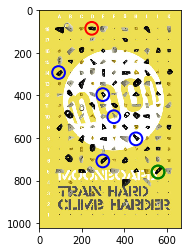

['A5-LH', 'C5-RH', 'D6-RH', 'B8-LH', 'F10-RH', 'F12-LH', 'H14-RH', 'E16-LH', 'D18-RH']


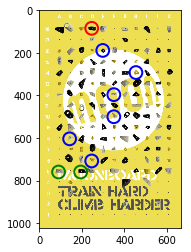

['J5-LH', 'J5-RH', 'E6-LH', 'H8-RH', 'F11-LH', 'E12-RH', 'A14-LH', 'D18-RH']


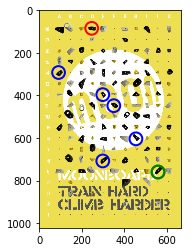

Repeat hand error ['G9-LH', 'F5-LH', 'F5-RH']
Repeat hand error ['G9-LH', 'H5-RH', 'D5-RH']
Repeat hand error ['G7-LH', 'F5-RH', 'D3-RH', 'D5-RH', 'B4-RH']
Same ['E6-LH', 'E6-RH', 'H8-RH', 'C10-LH', 'E12-RH', 'A14-LH', 'D18-RH']
Repeat hand error ['H8-LH', 'F5-LH', 'F5-RH']
Repeat hand error ['K8-LH', 'F5-LH', 'F5-RH']
['F5-RH', 'A5-LH', 'E6-RH', 'C10-LH', 'G14-RH', 'E18-LH']


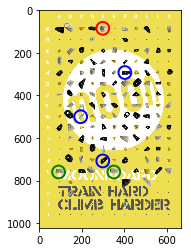

Repeat hand error ['H5-LH', 'H5-RH', 'E6-LH', 'D5-RH', 'F5-RH']
['J5-LH', 'J5-RH', 'E6-LH', 'H8-RH', 'F10-LH', 'H12-RH', 'G15-LH', 'K18-RH']


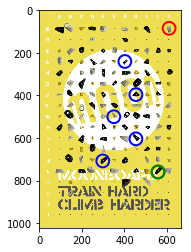

Repeat hand error ['F6-LH', 'B4-RH']
['C5-LH', 'C5-RH', 'E6-RH', 'A9-LH', 'F11-RH', 'C13-LH', 'D18-RH']


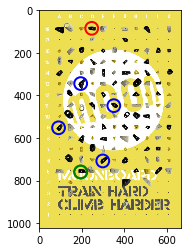

['F5-LH', 'F5-RH', 'F6-LH', 'H9-RH', 'D10-LH', 'H14-RH', 'C15-LH', 'E18-RH']


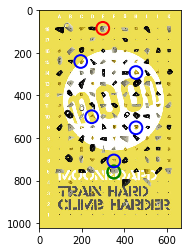

Repeat hand error ['K8-LH', 'F5-RH']
Repeat hand error ['F5-LH', 'F5-RH']
Repeat hand error ['F5-LH', 'F5-RH']
Repeat hand error ['F6-LH']
7 passCheck out of 400


In [32]:
passCount = 0
passGeneratedHandSequenceList = []
for i in range(40):
    x_initializer = np.zeros((1, 1, n_values))
    x_initializer = np.random.rand(1, 1, n_values) / 100
    a_initializer = np.random.rand(1, n_a) * 150
    c_initializer = np.random.rand(1, n_a) /2
    
    results, indices = predict_and_sample(inference_model, x_initializer, a_initializer, c_initializer)
    passCheck, outputListInString, outputListInIx = sanityCheckAndOutput(
        indices, holdIx_to_holdStr, handStringList, printError = True)
    if passCheck: 
        print(outputListInString)
        plotAProblem(outputListInString)
        passCount = passCount + 1
        passGeneratedHandSequenceList.append(outputListInString)
print (passCount, "passCheck out of 400")        

In [33]:
len(passGeneratedHandSequenceList)

7

### 4.4 - Produce move generator
To feed into GradeNet, we should transform from hand sequence to move sequence

In [34]:
# Feed in the hold feature.csv files
left_hold_feature_path = parent_wd + '/raw_data/HoldFeature2016LeftHand.csv'
right_hold_feature_path = parent_wd + '/raw_data/HoldFeature2016RightHand.csv'

LeftHandfeatures = pd.read_csv(left_hold_feature_path, dtype=str)
RightHandfeatures = pd.read_csv(right_hold_feature_path, dtype=str)
# convert features from pd dataframe to dictionary of left and right hand
RightHandfeature_dict = {}
LeftHandfeature_dict = {}
for index in RightHandfeatures.index:
    LeftHandfeature_item = LeftHandfeatures.loc[index]
    LeftHandfeature_dict[(int(LeftHandfeature_item['X_coord']), int(LeftHandfeature_item['Y_coord']))] = np.array(
        list(LeftHandfeature_item['Difficulties'])).astype(int)
    RightHandfeature_item = RightHandfeatures.loc[index]
    RightHandfeature_dict[(int(RightHandfeature_item['X_coord']), int(RightHandfeature_item['Y_coord']))] = np.array(
        list(RightHandfeature_item['Difficulties'])).astype(int)

In [35]:
# Output with a list of dictionary means moves
moveGeneratorFromStrList(['H5-LH', 'I6-RH', 'F7-LH', 'J10-RH', 'F13-LH', 'H14-RH', 'E16-LH', 'I18-RH'], string_mode = False)

[{'TargetHoldString': (5, 6),
  'TargetHoldHand': 0,
  'TargetHoldScore': array([5]),
  'RemainingHoldString': (8, 5),
  'RemainingHoldHand': 1,
  'RemainingHoldScore': array([3]),
  'dxdyRtoT': (-3, 1),
  'MovingHoldString': (7, 4),
  'MovingHoldHand': 0,
  'MovingHoldScore': array([6]),
  'dxdyMtoT': (-2, 2),
  'FootPlacement': [0, 0, 0, 1, 1, 1, 0],
  'MoveSuccessRate': array([13.928304])},
 {'TargetHoldString': (9, 9),
  'TargetHoldHand': 1,
  'TargetHoldScore': array([5]),
  'RemainingHoldString': (5, 6),
  'RemainingHoldHand': 0,
  'RemainingHoldScore': array([5]),
  'dxdyRtoT': (4, 3),
  'MovingHoldString': (8, 5),
  'MovingHoldHand': 1,
  'MovingHoldScore': array([3]),
  'dxdyMtoT': (1, 4),
  'FootPlacement': [0, 0, 1, 0, 0, 0, 1],
  'MoveSuccessRate': array([9.18649979])},
 {'TargetHoldString': (5, 12),
  'TargetHoldHand': 0,
  'TargetHoldScore': array([3]),
  'RemainingHoldString': (9, 9),
  'RemainingHoldHand': 1,
  'RemainingHoldScore': array([5]),
  'dxdyRtoT': (-4, 3),
  

### 4.5 - Generate moves and save the result (Don't overwrite)
Two things to save:
1. Move sequence -- For GradeNet and StyleNet purpose
2. List of holds -- For ploting purpose

In [37]:
save_path = cwd + '/MediumProblemOfDeepRouteSet_v1'

In [38]:
dim22Vec, listOfSavedSequence = moveGeneratorForAllGeneratedProblem(passGeneratedHandSequenceList, save_path, "HardDeepRouteSet_v1_id", print_result = False)

result saved. Store  7 out of 7


In [633]:
save_pickle(listOfSavedSequence, cwd + '/MediumProblemSequenceOfDeepRouteSet_v1')

In [103]:
dim22Vec

{'HardDeepRouteSet_v1_id1': array([[ 5.        ,  9.        ,  4.        ,  3.        ,  0.        ],
        [ 6.        ,  9.        , 11.        , 14.        , 17.        ],
        [ 0.        ,  1.        ,  0.        ,  1.        ,  0.        ],
        [ 5.        ,  5.        ,  6.        ,  4.        ,  5.        ],
        [ 7.        ,  5.        ,  9.        ,  4.        ,  3.        ],
        [ 4.        ,  6.        ,  9.        , 11.        , 14.        ],
        [ 3.        ,  5.        ,  5.        ,  6.        ,  4.        ],
        [-2.        ,  4.        , -5.        , -1.        , -3.        ],
        [ 2.        ,  3.        ,  2.        ,  3.        ,  3.        ],
        [ 7.        ,  7.        ,  5.        ,  9.        ,  4.        ],
        [ 4.        ,  4.        ,  6.        ,  9.        , 11.        ],
        [ 6.        ,  3.        ,  5.        ,  5.        ,  6.        ],
        [-2.        ,  2.        , -1.        , -6.        , -4.        ]

### 4.6 - Plot stored file

In [42]:
with open(parent_wd + "/out/MediumProblemSequenceOfDeepRouteSet_v1", 'rb') as f:
    listOfSavedSequence = pickle.load(f)

In [43]:
len(listOfSavedSequence)

65

MediumRouteSet_v1_id 1
beta ['E6-LH', 'E6-RH', 'I10-RH', 'C13-LH', 'E16-RH', 'A18-LH']


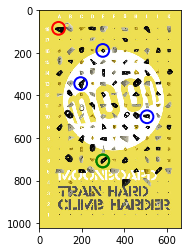

MediumRouteSet_v1_id 2
beta ['H5-LH', 'H5-RH', 'E6-LH', 'H8-RH', 'F10-LH', 'H12-RH', 'G15-LH', 'K18-RH']


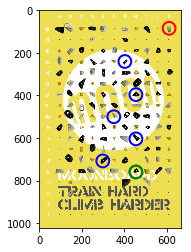

MediumRouteSet_v1_id 3
beta ['G2-LH', 'G2-RH', 'F5-LH', 'F5-RH', 'B8-LH', 'F10-RH', 'E13-LH', 'H14-RH', 'E18-LH']


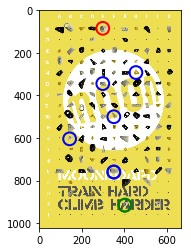

MediumRouteSet_v1_id 4
beta ['A5-LH', 'A5-RH', 'D5-RH', 'B8-LH', 'F10-RH', 'F12-LH', 'J13-RH', 'G15-LH', 'K18-RH']


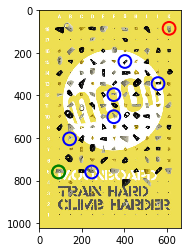

MediumRouteSet_v1_id 5
beta ['A5-LH', 'C5-RH', 'B6-LH', 'E9-RH', 'D11-LH', 'I14-RH', 'E18-LH']


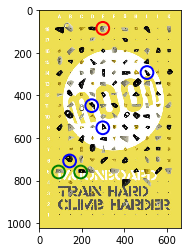

MediumRouteSet_v1_id 6
beta ['K5-LH', 'K5-RH', 'G6-LH', 'J9-RH', 'F14-LH', 'E18-RH']


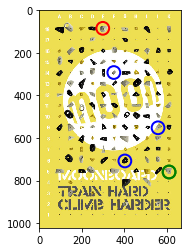

MediumRouteSet_v1_id 7
beta ['E6-LH', 'E6-RH', 'F10-RH', 'C13-LH', 'D18-RH']


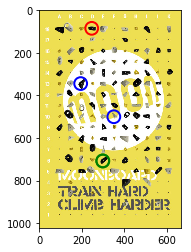

MediumRouteSet_v1_id 8
beta ['E6-LH', 'E6-RH', 'F10-RH', 'C13-LH', 'E16-RH', 'G18-LH']


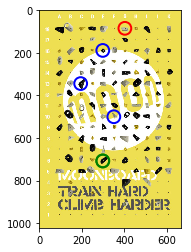

MediumRouteSet_v1_id 9
beta ['E6-LH', 'E6-RH', 'H8-RH', 'C10-LH', 'G14-RH', 'D18-LH']


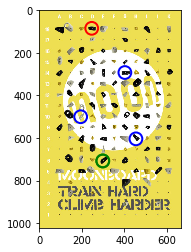

MediumRouteSet_v1_id 10
beta ['A5-LH', 'A5-RH', 'C5-LH', 'E8-RH', 'F10-LH', 'H12-RH', 'G15-LH', 'K18-RH']


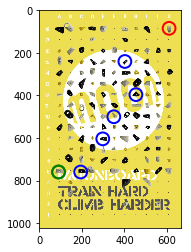

MediumRouteSet_v1_id 11
beta ['C5-LH', 'C5-RH', 'E6-RH', 'A9-LH', 'F11-RH', 'C13-LH', 'I14-RH', 'G18-LH']


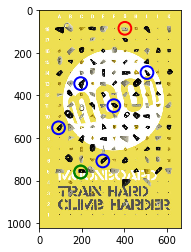

MediumRouteSet_v1_id 12
beta ['B4-LH', 'C5-RH', 'D6-RH', 'A9-LH', 'F11-RH', 'F13-LH', 'H16-RH', 'D18-LH']


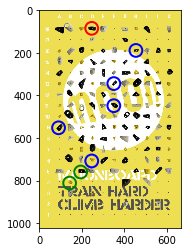

MediumRouteSet_v1_id 13
beta ['A5-LH', 'E6-RH', 'C10-LH', 'C13-LH', 'E18-RH']


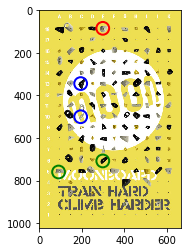

MediumRouteSet_v1_id 14
beta ['B4-LH', 'C5-RH', 'D6-RH', 'D10-LH', 'G11-RH', 'F15-LH', 'H18-RH']


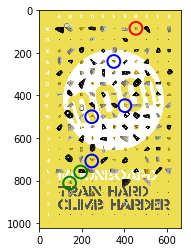

MediumRouteSet_v1_id 15
beta ['A5-RH', 'C5-LH', 'E6-RH', 'C8-LH', 'F11-RH', 'C13-LH', 'D18-RH']


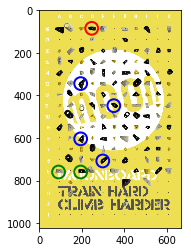

MediumRouteSet_v1_id 16
beta ['F5-LH', 'F5-RH', 'F10-RH', 'C13-LH', 'E16-RH', 'G18-LH']


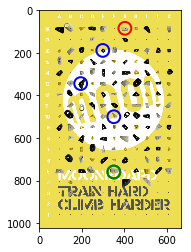

MediumRouteSet_v1_id 17
beta ['F5-LH', 'F5-RH', 'C13-LH', 'D18-RH']


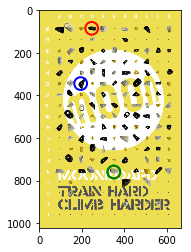

MediumRouteSet_v1_id 18
beta ['F5-LH', 'F5-RH', 'A5-LH', 'B8-LH', 'F10-RH', 'E13-LH', 'I14-RH', 'G18-LH']


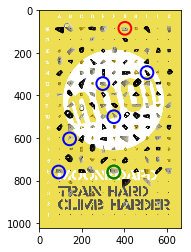

MediumRouteSet_v1_id 19
beta ['H5-LH', 'H5-RH', 'E6-LH', 'H8-RH', 'E9-LH', 'F10-RH', 'C13-LH', 'D18-RH']


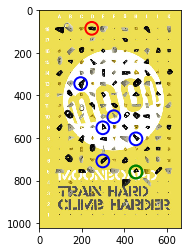

MediumRouteSet_v1_id 20
beta ['F5-LH', 'F5-RH', 'C10-LH', 'F11-RH', 'F14-LH', 'I18-RH']


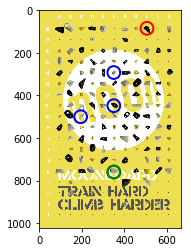

MediumRouteSet_v1_id 21
beta ['F5-LH', 'F5-RH', 'B8-LH', 'F10-RH', 'E13-LH', 'I16-RH', 'G18-LH']


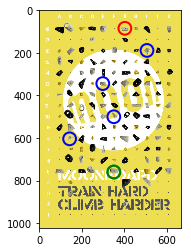

MediumRouteSet_v1_id 22
beta ['C5-LH', 'C5-RH', 'D6-RH', 'B8-LH', 'F10-RH', 'F12-LH', 'H14-RH', 'F15-LH', 'H18-RH']


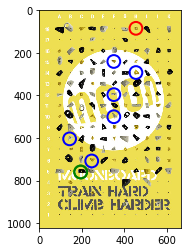

MediumRouteSet_v1_id 23
beta ['D3-RH', 'B4-LH', 'D6-RH', 'C7-LH', 'G11-RH', 'D13-LH', 'D16-RH', 'C18-LH']


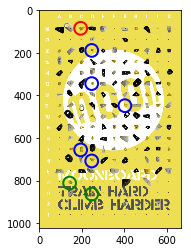

MediumRouteSet_v1_id 24
beta ['G2-LH', 'G2-RH', 'H5-LH', 'H5-RH', 'E8-LH', 'E9-RH', 'D10-LH', 'I12-RH', 'F15-LH', 'H18-RH']


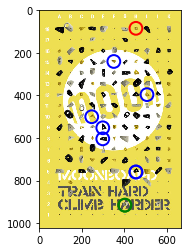

MediumRouteSet_v1_id 25
beta ['A5-LH', 'A5-RH', 'D5-RH', 'B8-LH', 'F10-RH', 'F12-LH', 'J13-RH', 'H16-LH', 'K18-RH']


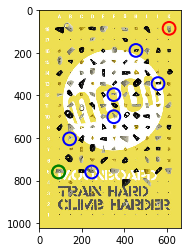

MediumRouteSet_v1_id 26
beta ['E6-LH', 'E6-RH', 'F11-RH', 'C13-LH', 'D18-RH']


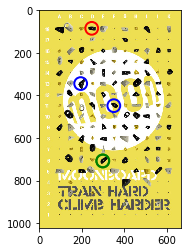

MediumRouteSet_v1_id 27
beta ['F5-LH', 'F5-RH', 'J8-RH', 'F10-LH', 'I13-RH', 'G15-LH', 'K18-RH']


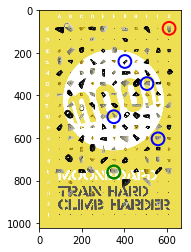

MediumRouteSet_v1_id 28
beta ['H5-LH', 'H5-RH', 'E6-LH', 'G9-RH', 'C10-LH', 'G14-RH', 'E16-LH', 'I18-RH']


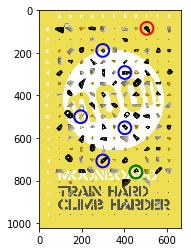

MediumRouteSet_v1_id 29
beta ['H5-LH', 'H5-RH', 'E6-LH', 'G9-RH', 'C13-LH', 'D15-RH', 'A18-LH']


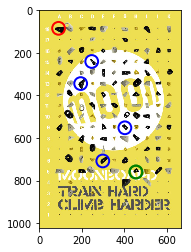

MediumRouteSet_v1_id 30
beta ['E6-LH', 'E6-RH', 'E8-LH', 'F10-RH', 'C13-LH', 'H14-RH', 'H16-LH', 'K18-RH']


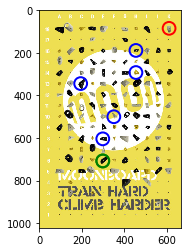

MediumRouteSet_v1_id 31
beta ['G2-LH', 'G2-RH', 'F5-LH', 'F5-RH', 'B8-LH', 'E10-RH', 'A12-LH', 'E13-RH', 'B16-LH', 'G18-RH']


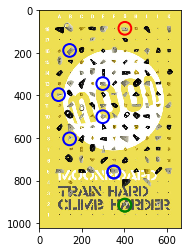

MediumRouteSet_v1_id 32
beta ['J5-LH', 'J5-RH', 'E6-LH', 'H8-RH', 'E9-LH', 'F10-RH', 'C13-LH', 'D18-RH']


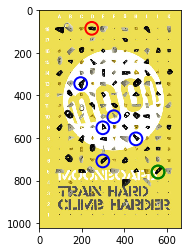

MediumRouteSet_v1_id 33
beta ['K5-LH', 'K5-RH', 'G6-LH', 'J9-RH', 'F13-LH', 'H14-RH', 'D18-LH']


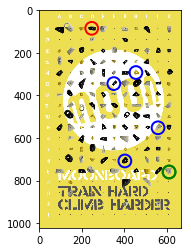

MediumRouteSet_v1_id 34
beta ['E6-LH', 'E6-RH', 'H8-RH', 'C10-LH', 'G14-RH', 'E16-LH', 'I18-RH']


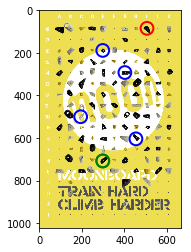

MediumRouteSet_v1_id 35
beta ['F5-LH', 'F5-RH', 'J8-RH', 'E10-LH', 'I14-RH', 'E18-LH']


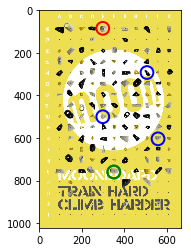

MediumRouteSet_v1_id 36
beta ['F5-LH', 'F5-RH', 'C5-LH', 'E6-RH', 'B8-LH', 'F10-RH', 'C13-LH', 'H14-RH', 'G15-LH', 'K18-RH']


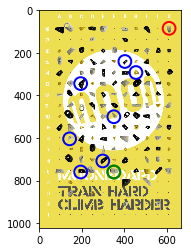

MediumRouteSet_v1_id 37
beta ['G4-LH', 'G4-RH', 'E6-LH', 'E6-RH', 'C8-LH', 'F11-RH', 'C13-LH', 'D18-RH']


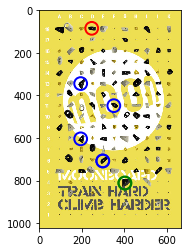

MediumRouteSet_v1_id 38
beta ['A5-LH', 'C5-RH', 'E6-LH', 'G9-RH', 'D11-LH', 'I14-RH', 'G18-LH']


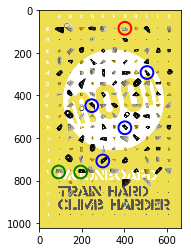

MediumRouteSet_v1_id 39
beta ['E6-LH', 'E6-RH', 'G4-RH', 'E6-LH', 'E8-RH', 'A9-LH', 'F11-RH', 'C13-LH', 'I14-RH', 'G18-LH']


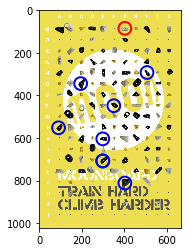

MediumRouteSet_v1_id 40
beta ['F5-RH', 'A5-LH', 'C13-LH', 'D18-RH']


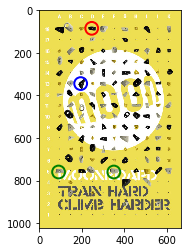

MediumRouteSet_v1_id 41
beta ['C5-LH', 'C5-RH', 'F10-RH', 'C13-LH', 'D18-RH']


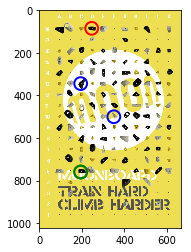

MediumRouteSet_v1_id 42
beta ['H5-LH', 'H5-RH', 'E6-LH', 'E6-RH', 'E8-LH', 'H10-RH', 'C13-LH', 'D15-RH', 'A18-LH']


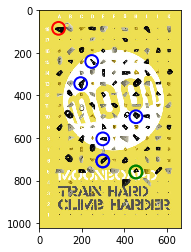

MediumRouteSet_v1_id 43
beta ['J5-LH', 'J5-RH', 'E6-LH', 'G9-RH', 'C13-LH', 'D15-RH', 'A18-LH']


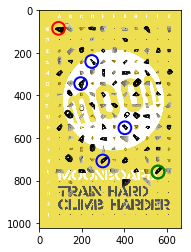

MediumRouteSet_v1_id 44
beta ['H5-LH', 'H5-RH', 'E6-LH', 'H8-RH', 'F10-LH', 'H12-RH', 'G15-LH', 'G17-RH', 'D18-LH']


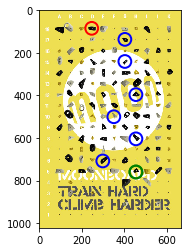

MediumRouteSet_v1_id 45
beta ['F5-LH', 'F5-RH', 'A9-LH', 'F11-RH', 'C13-LH', 'I14-RH', 'G18-LH']


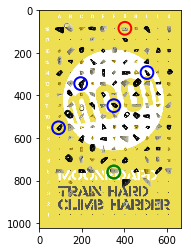

MediumRouteSet_v1_id 46
beta ['J5-LH', 'J5-RH', 'G6-LH', 'I9-RH', 'F13-LH', 'H16-RH', 'D18-LH']


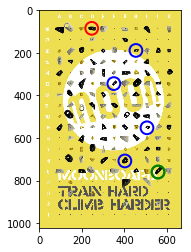

MediumRouteSet_v1_id 47
beta ['F5-LH', 'F5-RH', 'C5-LH', 'E8-RH', 'A9-LH', 'F11-RH', 'C13-LH', 'I14-RH', 'G18-LH']


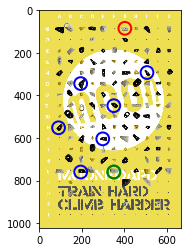

MediumRouteSet_v1_id 48
beta ['E6-LH', 'E6-RH', 'F10-RH', 'C13-LH', 'D15-RH', 'A18-LH']


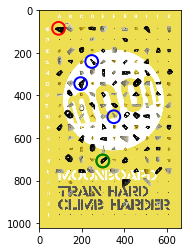

MediumRouteSet_v1_id 49
beta ['G4-LH', 'G4-RH', 'E6-LH', 'H8-RH', 'C10-LH', 'E12-RH', 'A14-LH', 'D18-RH']


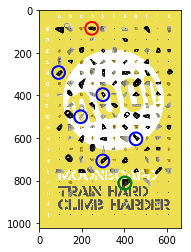

MediumRouteSet_v1_id 50
beta ['K5-RH', 'F5-LH', 'I10-RH', 'C13-LH', 'E16-RH', 'D18-LH']


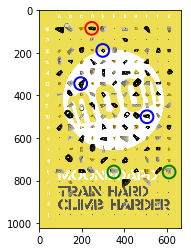

MediumRouteSet_v1_id 51
beta ['J5-LH', 'J5-RH', 'G6-LH', 'I10-RH', 'F13-LH', 'H16-RH', 'D18-LH']


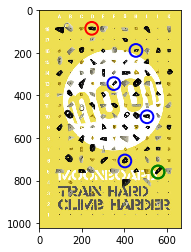

MediumRouteSet_v1_id 52
beta ['A5-RH', 'C5-LH', 'E8-RH', 'C10-LH', 'G14-RH', 'E18-LH']


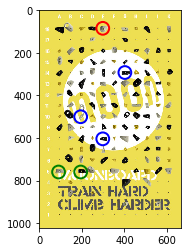

MediumRouteSet_v1_id 53
beta ['B3-RH', 'A5-LH', 'E6-RH', 'C10-LH', 'G13-RH', 'E18-LH']


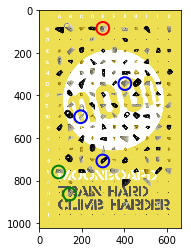

MediumRouteSet_v1_id 54
beta ['E6-LH', 'C5-RH', 'E6-LH', 'H8-RH', 'E9-LH', 'G10-RH', 'C13-LH', 'D18-RH']


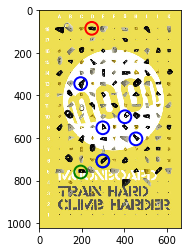

MediumRouteSet_v1_id 55
beta ['H5-LH', 'H5-RH', 'E6-LH', 'E6-RH', 'C8-LH', 'F11-RH', 'C13-LH', 'D18-RH']


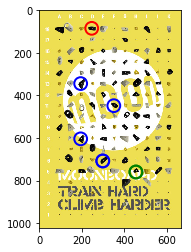

MediumRouteSet_v1_id 56
beta ['E6-LH', 'E6-RH', 'A9-LH', 'F11-RH', 'C13-LH', 'D18-RH']


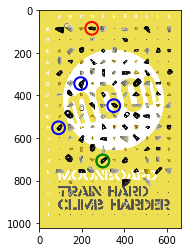

MediumRouteSet_v1_id 57
beta ['E6-LH', 'E6-RH', 'E8-LH', 'F10-RH', 'C13-LH', 'D18-RH']


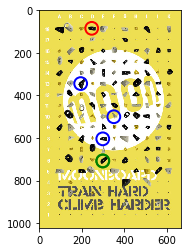

MediumRouteSet_v1_id 58
beta ['I5-RH', 'E6-LH', 'F10-RH', 'C13-LH', 'D18-RH']


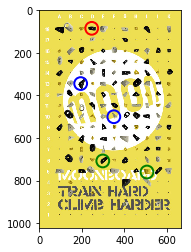

MediumRouteSet_v1_id 59
beta ['F6-LH', 'F5-RH', 'A5-LH', 'A5-RH', 'B8-LH', 'F10-RH', 'E13-LH', 'I16-RH', 'G18-LH']


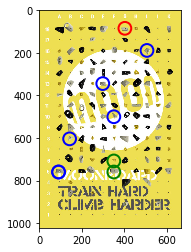

MediumRouteSet_v1_id 60
beta ['A5-LH', 'A5-RH', 'B8-LH', 'F10-RH', 'E14-LH', 'G18-RH']


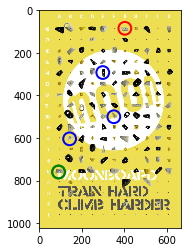

MediumRouteSet_v1_id 61
beta ['J5-LH', 'J5-RH', 'H8-RH', 'C10-LH', 'D15-RH', 'A18-LH']


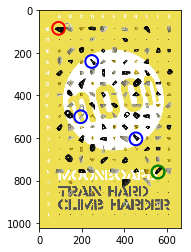

MediumRouteSet_v1_id 62
beta ['C5-LH', 'C5-RH', 'A5-LH', 'F10-RH', 'C13-LH', 'D18-RH']


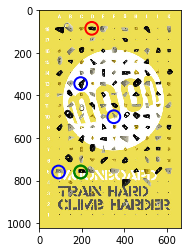

MediumRouteSet_v1_id 63
beta ['H5-LH', 'H5-RH', 'E6-LH', 'E6-RH', 'A9-LH', 'F11-RH', 'C13-LH', 'D18-RH']


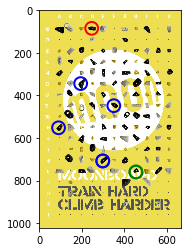

MediumRouteSet_v1_id 64
beta ['B4-LH', 'C5-RH', 'E6-LH', 'G9-RH', 'C13-LH', 'D18-RH']


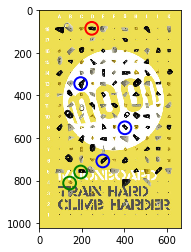

MediumRouteSet_v1_id 65
beta ['I5-RH', 'F5-LH', 'F10-RH', 'C13-LH', 'E16-RH', 'D18-LH']


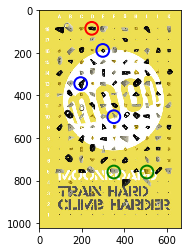

In [44]:
count = 1
for seq in listOfSavedSequence:
    print ("MediumRouteSet_v1_id", count)
    print ("beta", seq)
    plotAProblem(seq)
    count = count + 1

**Space to play with**: 

* Initial conditions like x,a,c can be changed
* Should compare the similarity with the training set. 
* Package the DeepRouteSet with gradeNet to predict the grade

#### 3.3 - Generate moonboard problem


**References**

This program is adapted from Andrew Ng coursera's course Jazz music
The ideas presented in this notebook came primarily from three computational music papers cited below. The implementation here also took significant inspiration and used many components from Ji-Sung Kim's GitHub repository.

- Ji-Sung Kim, 2016, [deepjazz](https://github.com/jisungk/deepjazz)
- Jon Gillick, Kevin Tang and Robert Keller, 2009. [Learning Jazz Grammars](http://ai.stanford.edu/~kdtang/papers/smc09-jazzgrammar.pdf)
- Robert Keller and David Morrison, 2007, [A Grammatical Approach to Automatic Improvisation](http://smc07.uoa.gr/SMC07%20Proceedings/SMC07%20Paper%2055.pdf)
- François Pachet, 1999, [Surprising Harmonies](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.5.7473&rep=rep1&type=pdf)